In [20]:
# import required packages
import numpy as np
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from collections import namedtuple as nt
from collections import defaultdict as ddict
from copy import deepcopy
import pickle
import pandas as pd

import sys
sys.path.append("./../") # adds parent directory to path
sys.path.append("/Users/will_milligan/PycharmProjects/MUTATOR_FINAL/venv/lib/python3.7/site-packages")
import xlrd

In [40]:
# figure stuff
sns.set_style('whitegrid')

mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10

In [39]:
# this is the object we use in simulations
in_path = '/Users/will_milligan/PycharmProjects/MUTATOR_FINAL/MSMC_NE_dict.pickle'
with open(in_path,'rb') as fin:
    MSMC = pickle.load(fin)
    
# our assumed parameters
SPLIT = 10000
BURN  = 60000
generation_time = 30

# record the relevant values for each population
x_values = np.array(list(MSMC.keys()))
CEU_values = [i[0] for i in MSMC.values()]
YRI_values = [i[1] for i in MSMC.values()]

# force each population curve to have the same value at SPLIT time
split_value = CEU_values[np.where(np.abs(x_values-SPLIT)==min(np.abs(x_values-SPLIT)))[0][0]]
ANC_pop_size = split_value
x_values = np.append(x_values,SPLIT)
CEU_values.append(ANC_pop_size)
YRI_values.append(ANC_pop_size)

# sort values based on time (since we added a value)
x_ord = np.argsort(x_values)
x_values = np.array([x_values[i] for i in x_ord])
CEU_values = np.array([CEU_values[i] for i in x_ord])
YRI_values = np.array([YRI_values[i] for i in x_ord])

# assign the ancestral population to have the same values as the CEU population
ANC_values = CEU_values

# assign all values farther in the past than the burn time to the value associated with the time closest to the burn time
ANC_values[x_values > BURN] = CEU_values[np.where(np.abs(x_values-BURN)==min(np.abs(x_values-BURN)))[0][0]]

In [ ]:
import openpyxl
from openpyxl import load_workbook
from collections import defaultdict as ddict

# load excel spreadsheet from schiifels and durbin 2017
workbook = load_workbook(filename="/Users/will_milligan/Desktop/Sella/Mutator/ng.3015-f3.xlsx")
workbook.sheetnames
sheet3 = workbook.active

# Dict format - {pop:{sample_name:{time:value}}}
# Row format - [pop,sample_name,#haplotypes,comment,time_index,time_left,time_right,NE_value]
MSMC_NE_dict = {'YRI':ddict(dict),'CEU':ddict(dict)}

#values only gives you cell values not cell objects
for row in sheet3.iter_rows(values_only=True):
    
    # dont use values that have a comment
    if row[3]: 
        continue
    
    # which population
    pop = row[0]
    
    # only car about YRI and CEU
    if pop == 'YRI' or pop == 'CEU': 
        sample_name = row[1]
        time_left = row[6]
        time_right = row[7]
        value = row[8]
    else:
        continue
    
    # record values 
    MSMC_NE_dict[pop][sample_name][time_left] = value
    if time_right == 'inf': 
        continue
    else:
        MSMC_NE_dict[pop][sample_name][time_right] = value

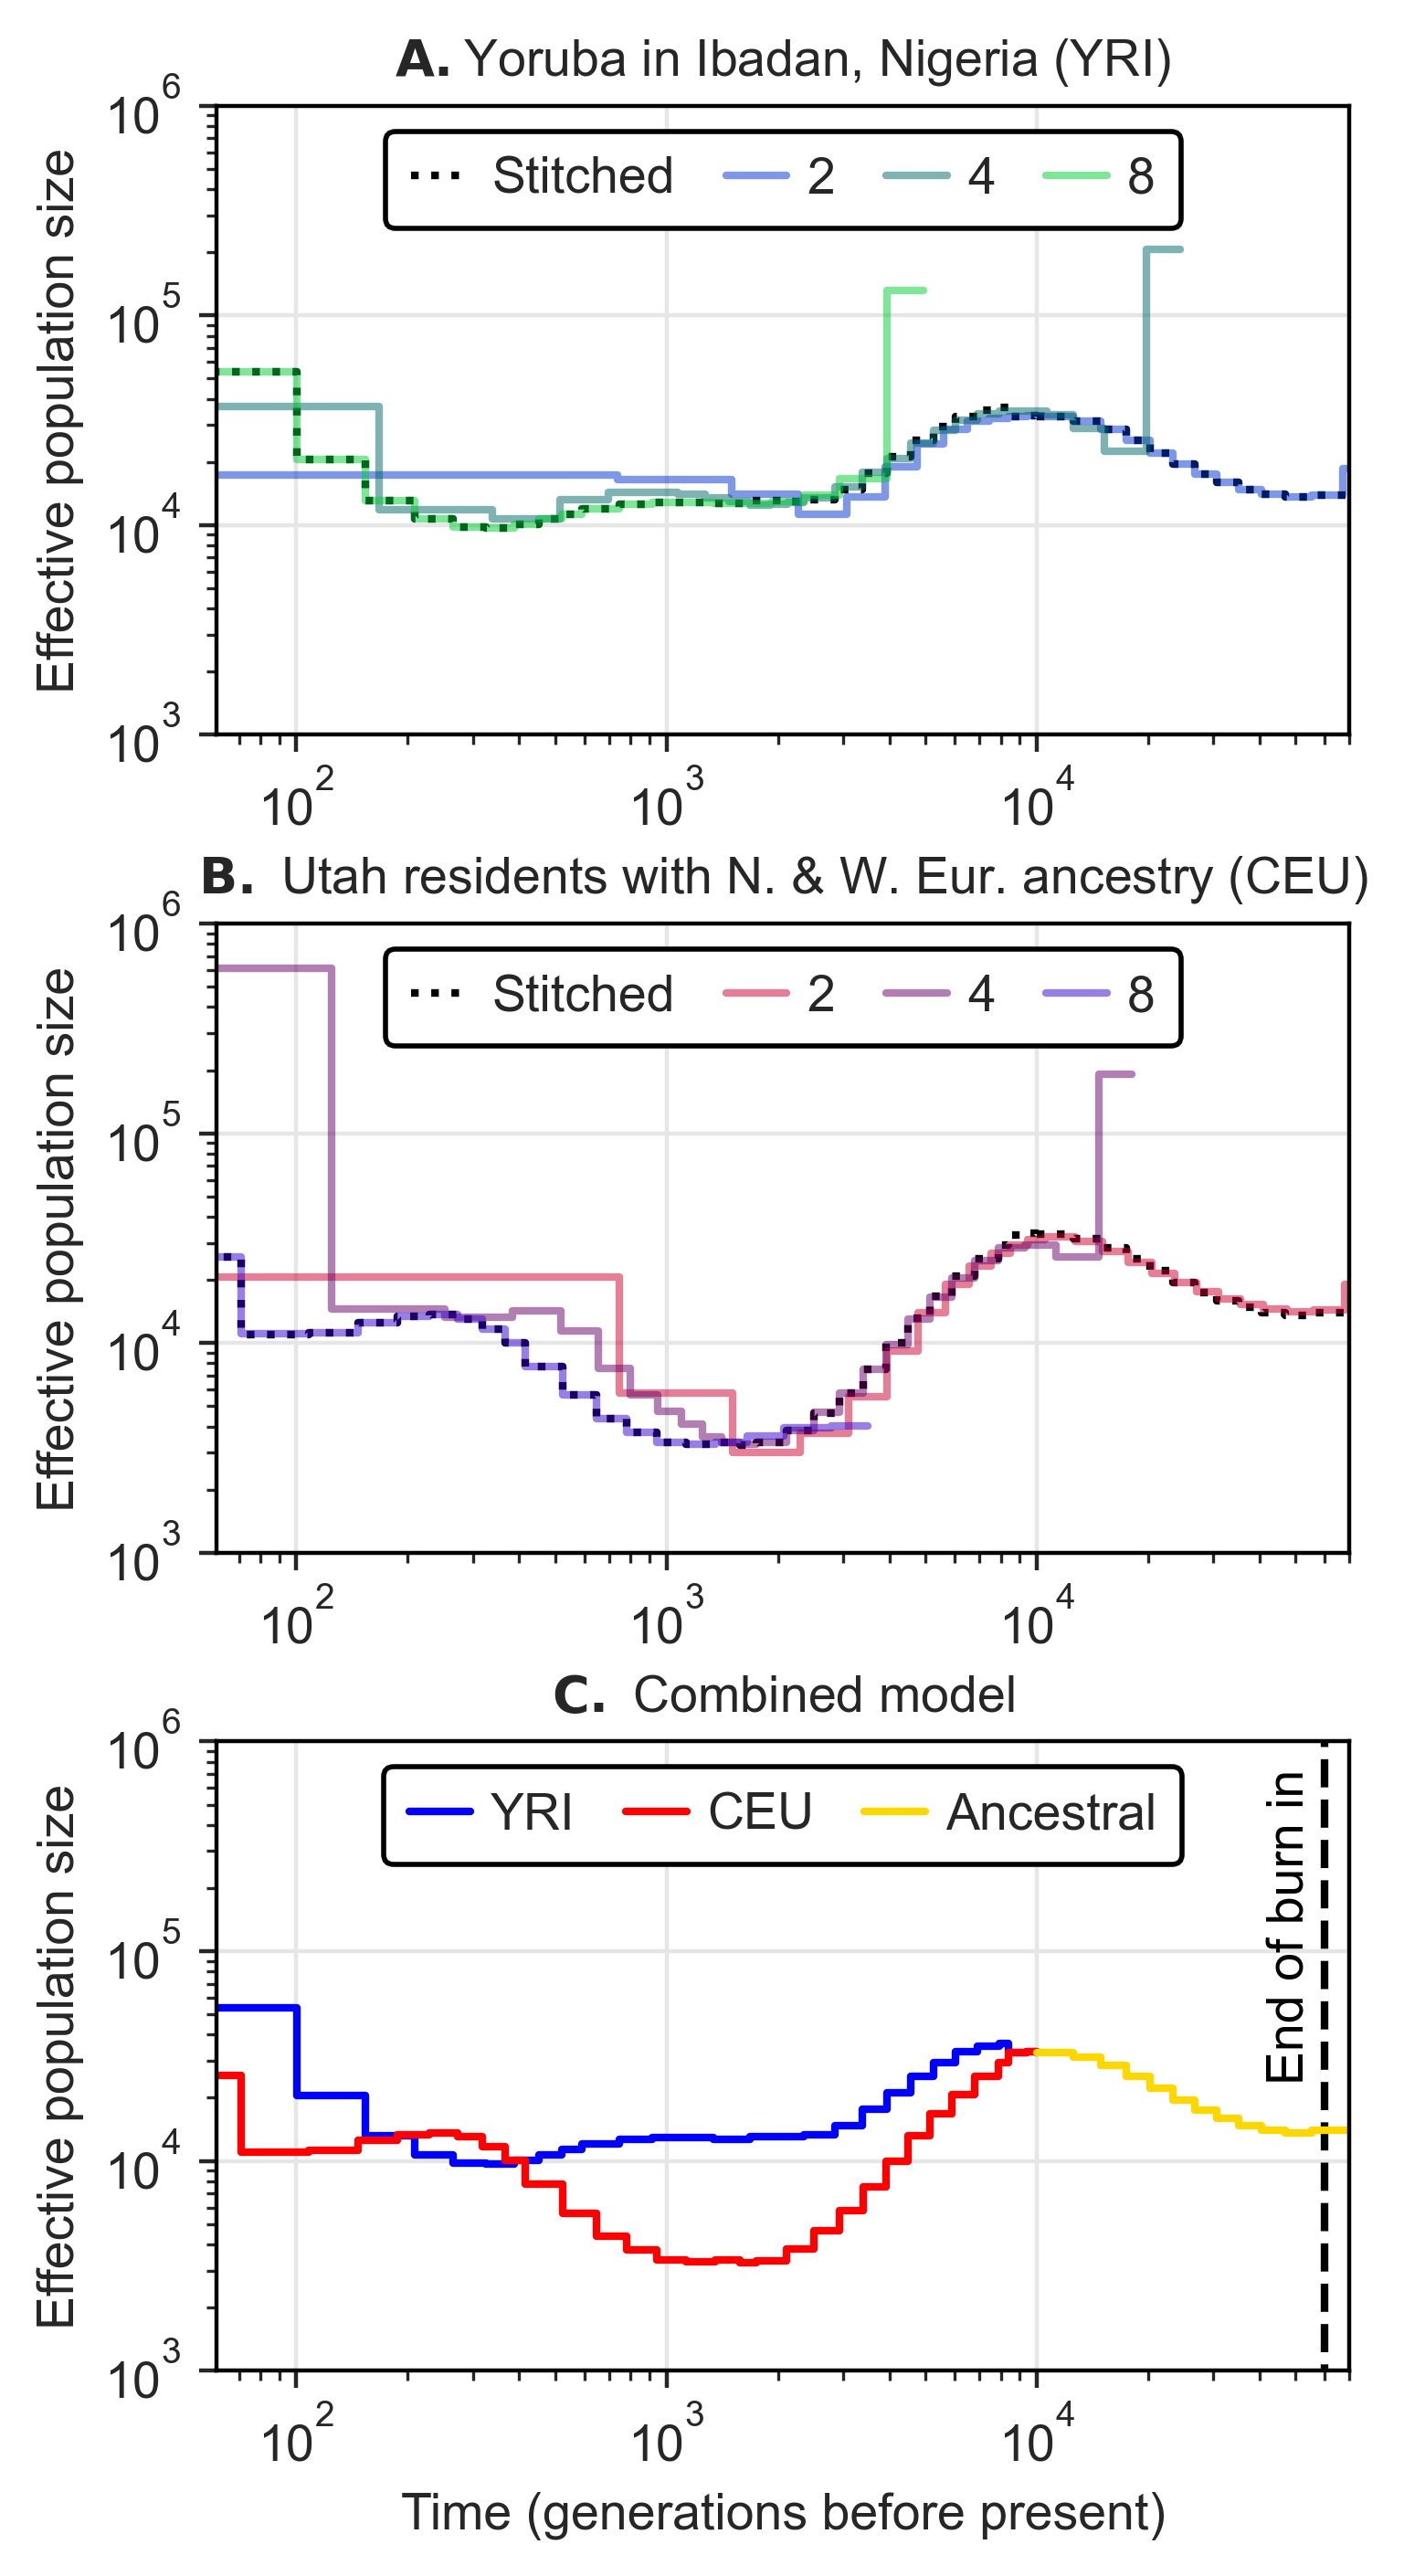

In [45]:
x_text = 70
y_text = 3e5

fig, (ax1,ax2,ax3) = plt.subplots(nrows = 3, ncols = 1, figsize=(4,8.21))

# plot the population curves we actually use
plt.sca(ax3)
plt.step(x_values[x_values<=SPLIT],YRI_values[x_values<=SPLIT],where='post',color='blue',label='YRI')
plt.step(x_values[x_values<=SPLIT],CEU_values[x_values<=SPLIT],where='post',color='red',label='CEU')
plt.step(x_values[x_values>=SPLIT],ANC_values[x_values>=SPLIT],where='post',color='gold',label='Ancestral')

# add some extra stuff
plt.vlines(BURN,ymin=0,ymax=1e7,linestyles='--',color='k')
plt.text(x = 42000, y = 26000, s = 'End of burn in',color='k',rotation = 90)
plt.xscale('log')
plt.xlim([61,70000])
plt.title(r'$\bf{C.}$ Combined model')
plt.ylim([1e3,1e6])
plt.yscale('log')
plt.xlabel('Time before present (generations)')
plt.ylabel('Effective population size')


for pop in MSMC_NE_dict.keys():
    if pop == 'YRI': 
        colors = {1:[0,0.2,0.8],2:[0,0.4,0.4],4:[0,0.8,0.2]}
        plt.sca(ax1)
        plt.title(r'$\bf{A.}$Yoruba in Ibadan, Nigeria (YRI)')
        
        # plot the stitched curve
        plt.step(x_values[x_values<=SPLIT],YRI_values[x_values<=SPLIT],where='post',color='k',label='Stitched',ls=':')
        plt.step(x_values[x_values>=SPLIT],CEU_values[x_values>=SPLIT],where='post',color='k',ls=':')
    else: 
        plt.sca(ax2)
        plt.title(r'$\bf{B.}$ Utah residents with N. & W. Eur. ancestry (CEU)')
        colors = {1:[0.8,0,0.2],2:[0.4,0,0.4],4:[0.2,0,0.8]}
        
        # plot the stitched curve
        plt.step(x_values[x_values<=SPLIT],CEU_values[x_values<=SPLIT],where='post',color='k',ls=':',label='Stitched')
        plt.step(x_values[x_values>=SPLIT],CEU_values[x_values>=SPLIT],where='post',color='k',ls=':')
    
    # plot individual population curves with different number of haplotypes
    for sample_name in np.array(list(MSMC_NE_dict[pop].keys()))[[1,0,2]]:
        color_now = colors[len(sample_name.split(','))]
        x1_values = np.sort(np.array(list(MSMC_NE_dict[pop][sample_name].keys())))
        y_values = np.array([MSMC_NE_dict[pop][sample_name][x] for x in x1_values])
        plt.step(x1_values/generation_time,y_values,where='post',color=color_now,alpha = 0.5,label='{}'.format(2*len(sample_name.split(','))))

# make the graphs pretty
for ax in [ax1,ax2,ax3]:
    ax.grid(color=[0.9,0.9,0.9,0])
    plt.sca(ax)
    plt.xscale('log')
    plt.xlim([61,70000])
    plt.ylim([1e3,1e6])
    plt.yscale('log')
    plt.legend(ncol=4,
               edgecolor='k',
               framealpha=1,
               loc='upper center',
              handlelength = 1.2,
              columnspacing = 1,
               handletextpad = 0.4,
               borderaxespad = 0.5,
               borderpad = 0.5)
    plt.tick_params(bottom=True, top=False, left=True, right=False)
    plt.tick_params(bottom=True, top=False, left=True, right=False,which='minor')
    plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    plt.ylabel('Effective population size')
    if ax == ax3:
        plt.xlabel('Time (generations before present)')
    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color('k')
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_color('k')
plt.subplots_adjust(hspace=0.3)